In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# load the raw data
df=pd.read_csv('data/Air_Quality.csv')

In [3]:
#Then I found that there are some missing values in the dataset. So I drop the rows with missing values. And the "message" column is not useful for the analysis, so I drop it.
df['Message'].isna().sum() #show number of missing values in the column 'Message'
clean_data = df.drop(columns=['Message'])

In [4]:
clean_data['Start_Date'] = pd.to_datetime(df['Start_Date'])
clean_data.dropna(subset=['Data Value'], inplace=True)

In [5]:
#Then I found that the 'Time Period' column is hard to analyze, so I need to split it into different columns.
unique_time_periods = df['Time Period'].unique()
unique_time_periods[:10]
# Function to extract season from the 'Time Period' column
def extract_season(time_period):
    if 'Winter' in time_period:
        return 'Winter'
    elif 'Spring' in time_period:
        return 'Spring'
    elif 'Summer' in time_period:
        return 'Summer'
    elif 'Fall' in time_period:
        return 'Fall'
    else:
        return 'Annual'  # mark non-seasonal data as 'Annual'

# Apply the function to the 'Time Period' column
clean_data['Season'] = df['Time Period'].apply(extract_season)
# Display the first few rows of the modified dataframe
# clean_data.sample(5)

In [6]:
#Since the type of 'Time Period' is string, I need to convert it to numeric type.
def calculate_year(time_period):
    parts = time_period.replace('-', ' ').split() # Split the string by spaces and by dash

    years = [int(part) for part in parts if part.isdigit()]
    
    # If there are two years, return the first year
    if len(years) == 2:
        if years[1] < 100:
            years[1] += years[0] - (years[0] % 100)  
        return years[0]  
    elif len(years) == 1:
        return years[0]  
    else:
        dash_parts = [part for part in time_period.split() if '-' in part]
        for part in dash_parts:

            split_years = part.split('-')
            if all(s.isdigit() for s in split_years):
                # Parse the years and return the first one
                range_years = [int(s) for s in split_years]
                #print(range_years)
                if range_years:
                    return range_years[0]
        return np.nan 
    
# Apply the function to calculate the representative year
clean_data['Year'] = df['Time Period'].apply(calculate_year)
# clean_data.sample(5)

In [7]:
#drop the row "Time Period"
clean_data.drop(columns=['Time Period'], inplace=True)
# clean_data.sample(5)

In [8]:
cleaned_file_path = 'data/clean_data.csv'
clean_data.to_csv(cleaned_file_path, index=False)

In [30]:
# clean_data.sample(5)

In [31]:
# clean_data['Geo Type Name'].value_counts()

In [33]:
# 加载GeoJSON文件
nyc_boroughs = gpd.read_file('data/nyc_boroughs.geojson')

# # 显示GeoDataFrame的前10行
# nyc_boroughs.head(10)

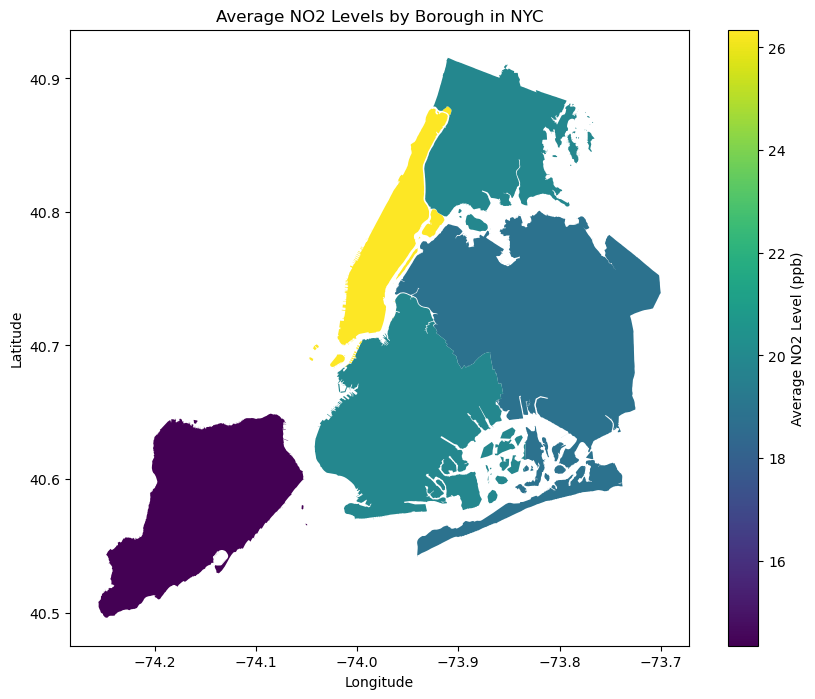

In [34]:
# 筛选NO2数据集中的NO2数据
no2_data = clean_data[clean_data['Name'] == 'Nitrogen dioxide (NO2)']
# 计算每个区的平均NO2水平
avg_no2_by_name = no2_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
# 将NO2数据集与GeoJSON文件合并
# 请确保'Geo Place Name'是NO2数据集中代表地区名称的列
merged_data = nyc_boroughs.merge(avg_no2_by_name, how='left', left_on='name', right_on='Geo Place Name')
# 绘制合并后的数据
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average NO2 Level (ppb)"})
plt.title('Average NO2 Levels by Borough in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


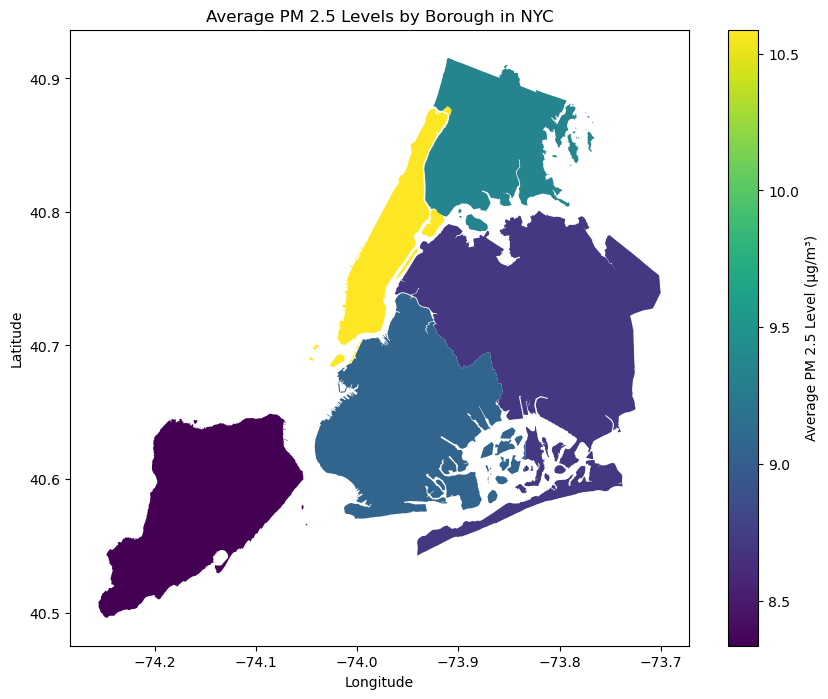

In [35]:
pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
avg_pm_by_name = pm_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = nyc_boroughs.merge(avg_pm_by_name, how='left', left_on='name', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average PM 2.5 Level (µg/m³)"})
plt.title('Average PM 2.5 Levels by Borough in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

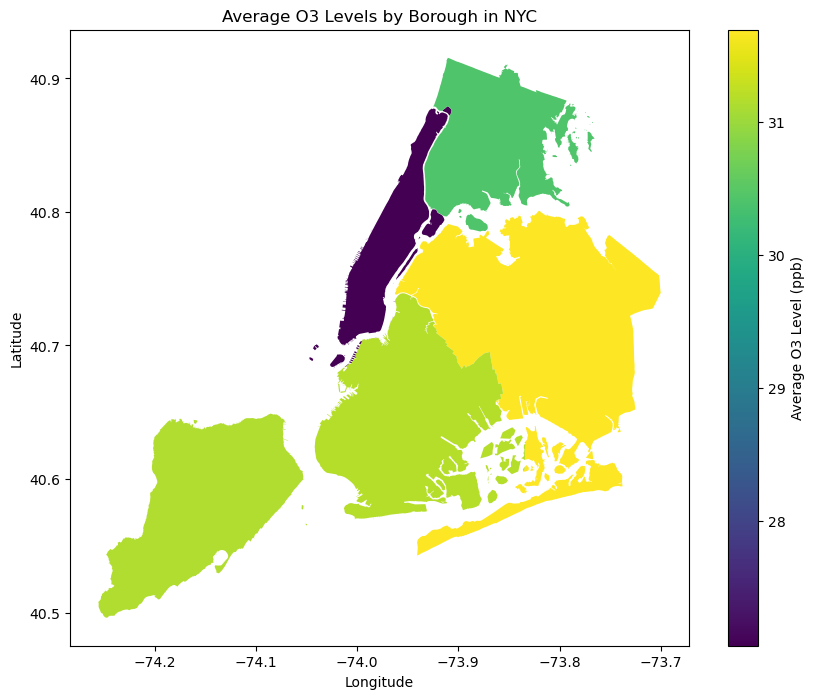

In [14]:
o3_data = clean_data[clean_data['Name'] == 'Ozone (O3)']
avg_o3_by_name = o3_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = nyc_boroughs.merge(avg_o3_by_name, how='left', left_on='name', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average O3 Level (ppb)"})
plt.title('Average O3 Levels by Borough in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [36]:
# 加载GeoJSON文件
uhf42_geo_path = 'data/UHF42.geo.json'
uhf42_gdf = gpd.read_file(uhf42_geo_path)
# Display the first few rows to confirm successful loading and to show the structure
# uhf42_gdf.head()


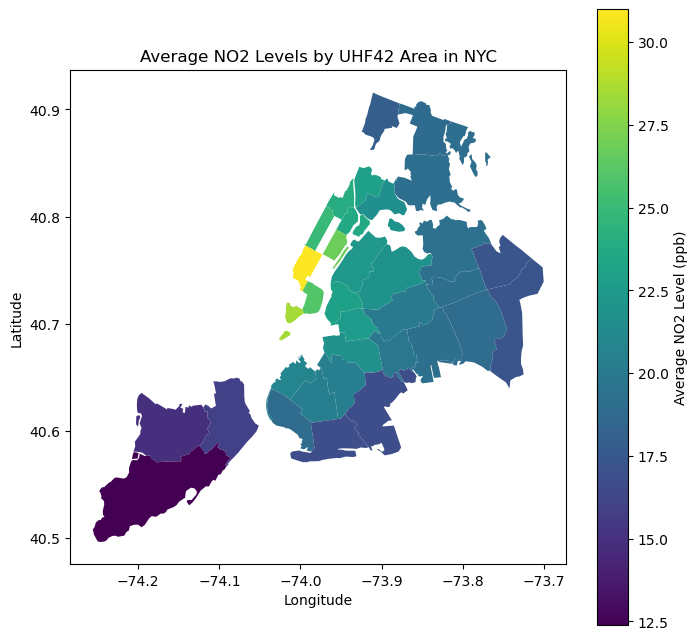

In [16]:
no2_data = clean_data[clean_data['Name'] == 'Nitrogen dioxide (NO2)']
# Calculate the average NO2 levels by UHF42 area
avg_no2_by_uhf42 = no2_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
# Merge the NO2 data with the UHF42 GeoDataFrame
merged_data = uhf42_gdf.merge(avg_no2_by_uhf42, how='left', left_on='GEONAME', right_on='Geo Place Name')
# Plotting the merged data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average NO2 Level (ppb)"})
plt.title('Average NO2 Levels by UHF42 Area in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

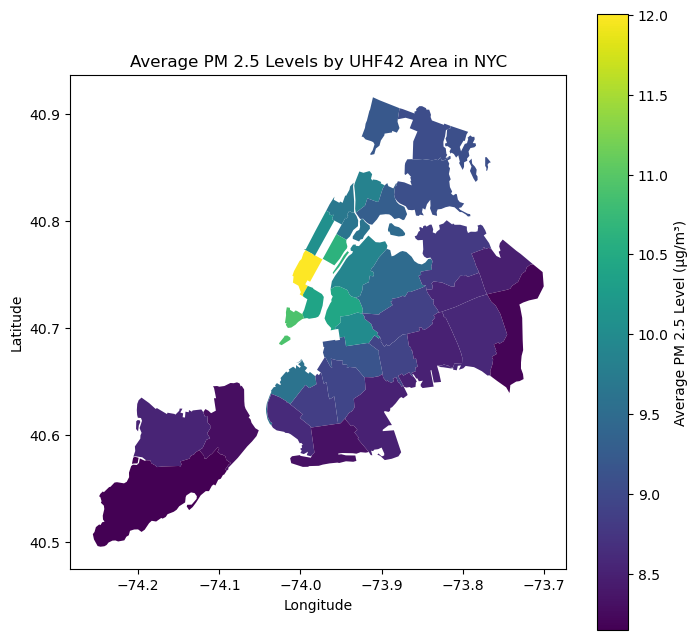

In [17]:
pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
avg_pm_by_uhf42 = pm_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = uhf42_gdf.merge(avg_pm_by_uhf42, how='left', left_on='GEONAME', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average PM 2.5 Level (µg/m³)"})
plt.title('Average PM 2.5 Levels by UHF42 Area in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


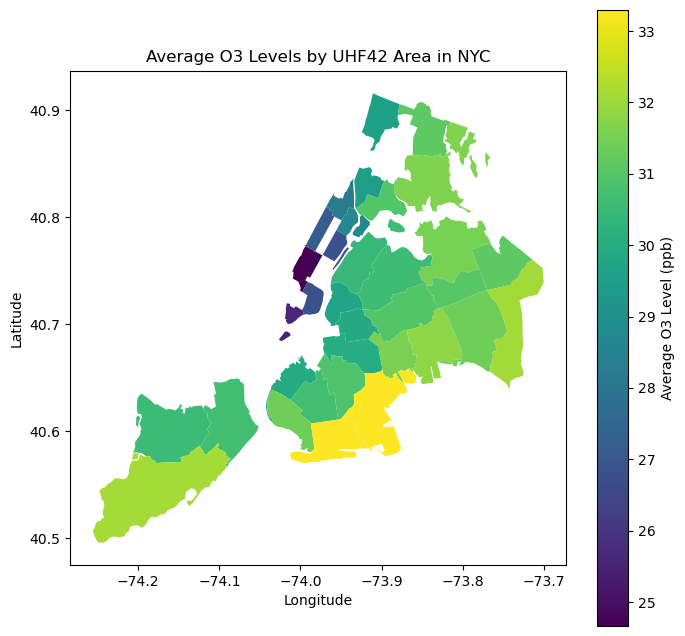

In [18]:
o3_data = clean_data[clean_data['Name'] == 'Ozone (O3)']
avg_o3_by_uhf42 = o3_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = uhf42_gdf.merge(avg_o3_by_uhf42, how='left', left_on='GEONAME', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average O3 Level (ppb)"})
plt.title('Average O3 Levels by UHF42 Area in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [37]:
# clean_data['Name'].value_counts()

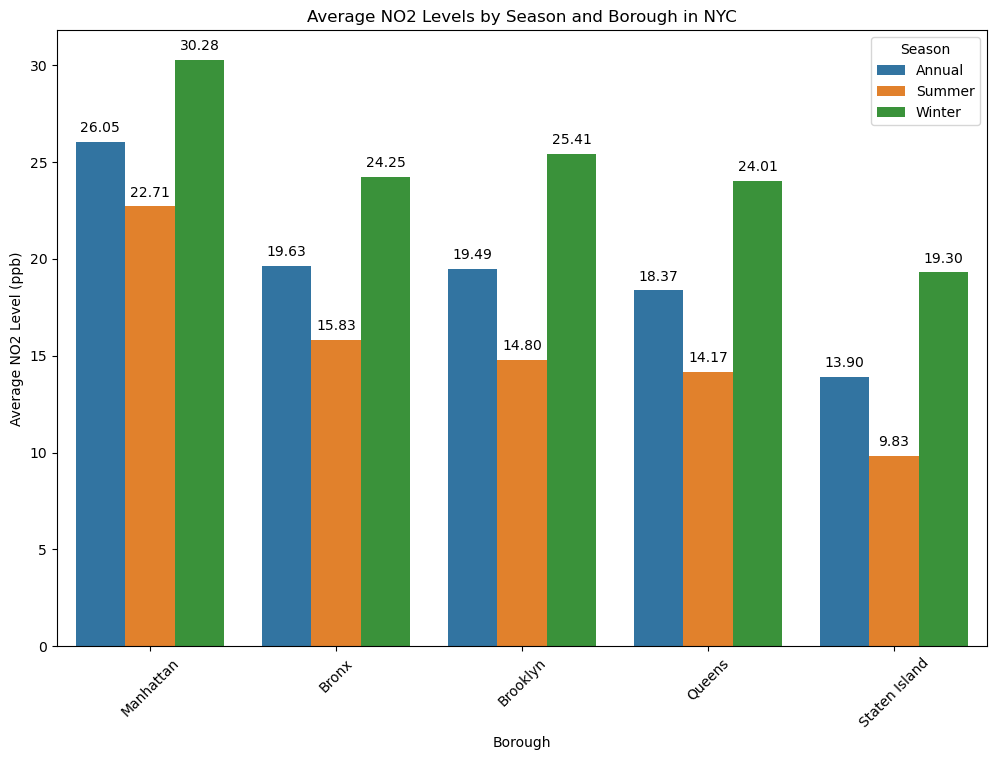

In [20]:
#分析不同季节的NO2水平 从不同的boroughs来分析（先要看Geo Place Name的类型是borough）
no2_data = clean_data[clean_data['Name'] == 'Nitrogen dioxide (NO2)']
no2_data = no2_data[no2_data['Geo Type Name'] == 'Borough']
# Calculate the average NO2 levels by season and borough
avg_no2_by_season_borough = no2_data.groupby(['Season', 'Geo Place Name'])['Data Value'].mean().reset_index()
borough_order = avg_no2_by_season_borough.groupby('Geo Place Name')['Data Value'].mean().sort_values(ascending=False).index
# Plotting the data用柱状图
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Geo Place Name', y='Data Value', hue='Season', data=avg_no2_by_season_borough, ax=ax, order=borough_order)
plt.title('Average NO2 Levels by Season and Borough in NYC')
plt.xlabel('Borough')
plt.ylabel('Average NO2 Level (ppb)')
plt.xticks(rotation=45)
# Add numbers above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

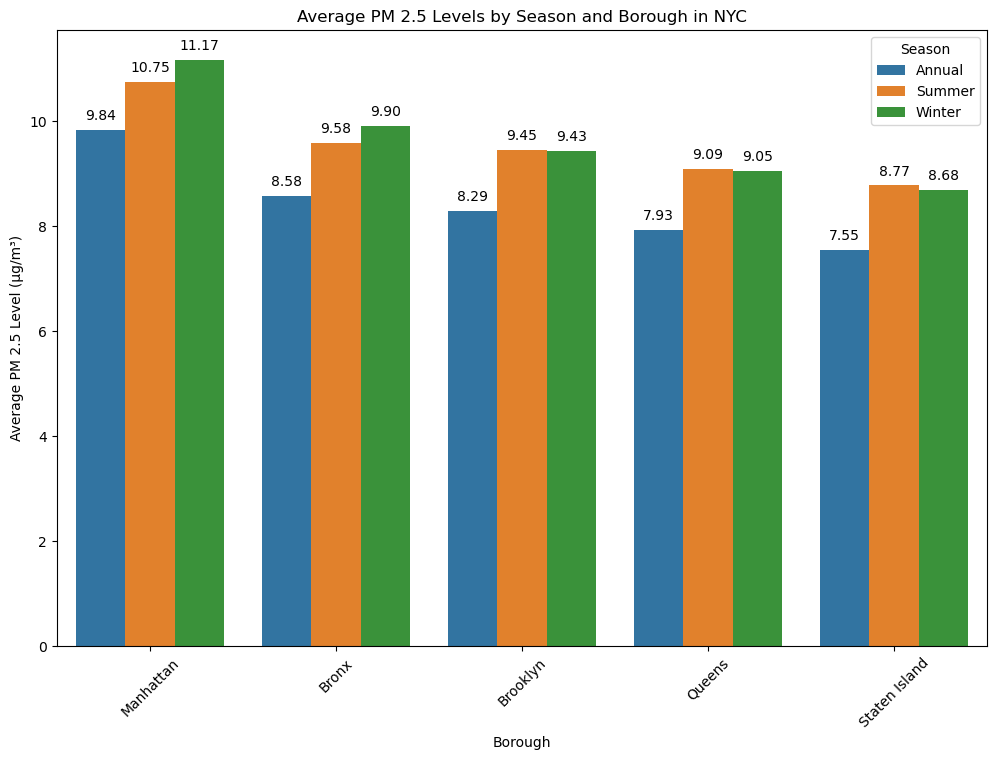

In [21]:
#分析不同季节的pm2.5水平 从不同的boroughs来分析（先要看Geo Place Name的类型是borough）
pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
pm_data = pm_data[pm_data['Geo Type Name'] == 'Borough']
# Calculate the average PM 2.5 levels by season and borough
avg_pm_by_season_borough = pm_data.groupby(['Season', 'Geo Place Name'])['Data Value'].mean().reset_index()
borough_order = avg_pm_by_season_borough.groupby('Geo Place Name')['Data Value'].mean().sort_values(ascending=False).index
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Geo Place Name', y='Data Value', hue='Season', data=avg_pm_by_season_borough, ax=ax, order=borough_order)
plt.title('Average PM 2.5 Levels by Season and Borough in NYC')
plt.xlabel('Borough')
plt.ylabel('Average PM 2.5 Level (µg/m³)')
plt.xticks(rotation=45)
# Add numbers above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()


c:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


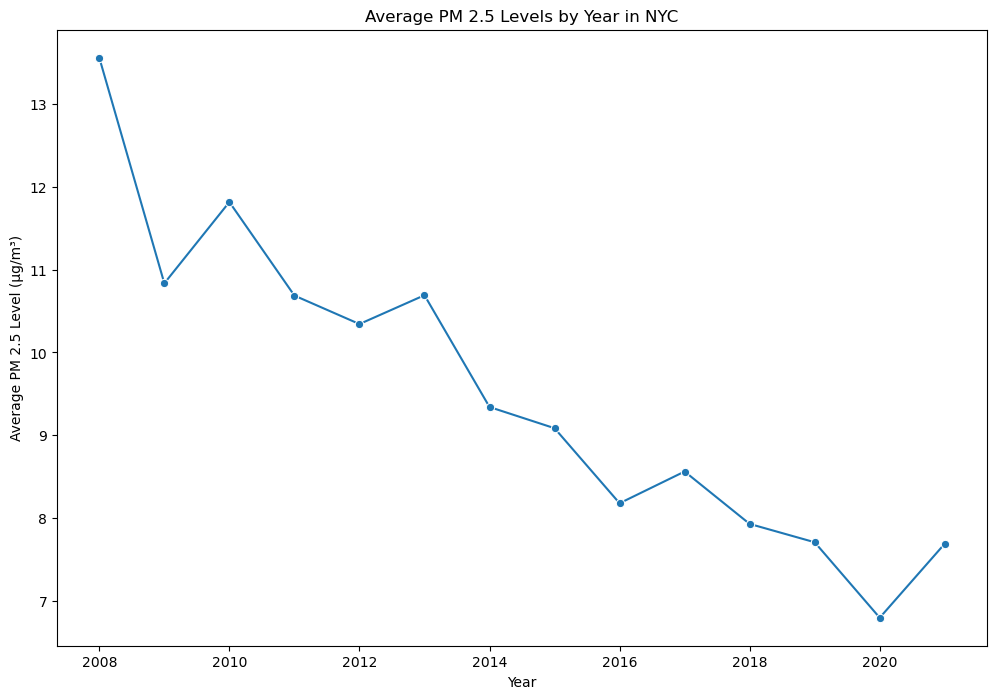

In [22]:
#分析不同年份的pm2.5水平
pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
# Calculate the average PM 2.5 levels by year
avg_pm_by_year = pm_data.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(x='Year', y='Data Value', data=avg_pm_by_year, ax=ax, marker='o')
plt.title('Average PM 2.5 Levels by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average PM 2.5 Level (µg/m³)')
plt.show()



In [39]:
asthma_data = clean_data[clean_data['Name'] == 'Asthma emergency department visits due to PM2.5']
# asthma_data.sample(5)

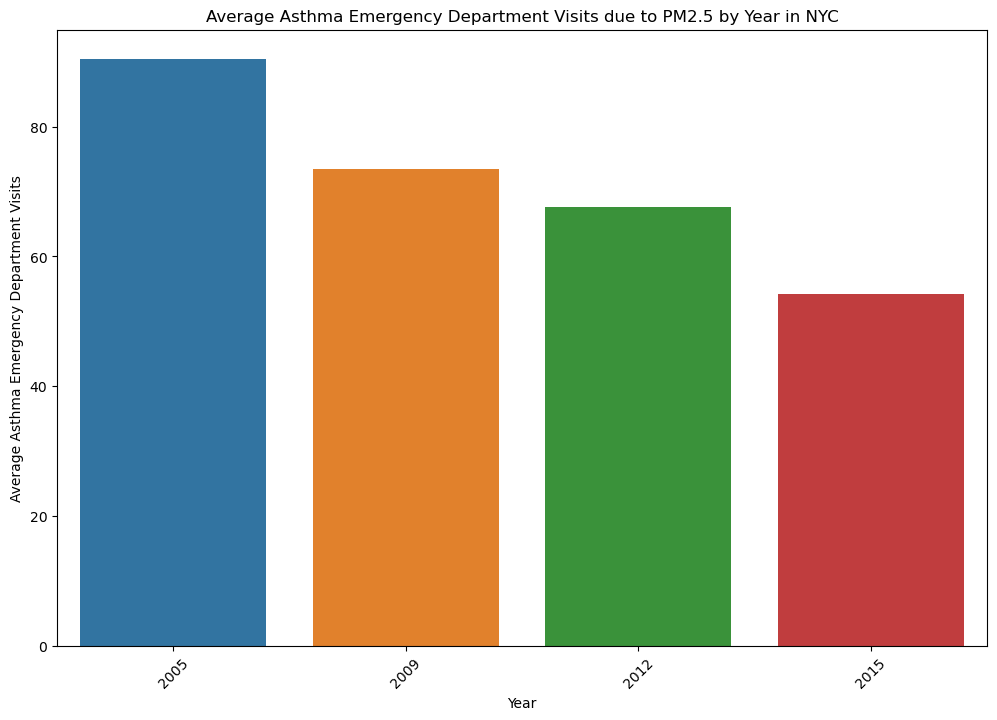

In [40]:
# Calculate the average asthma emergency department visits by year
avg_asthma_by_year = asthma_data.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Year', y='Data Value', data=avg_asthma_by_year, ax=ax)
plt.title('Average Asthma Emergency Department Visits due to PM2.5 by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average Asthma Emergency Department Visits')
plt.xticks(rotation=45)
plt.show()


c:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


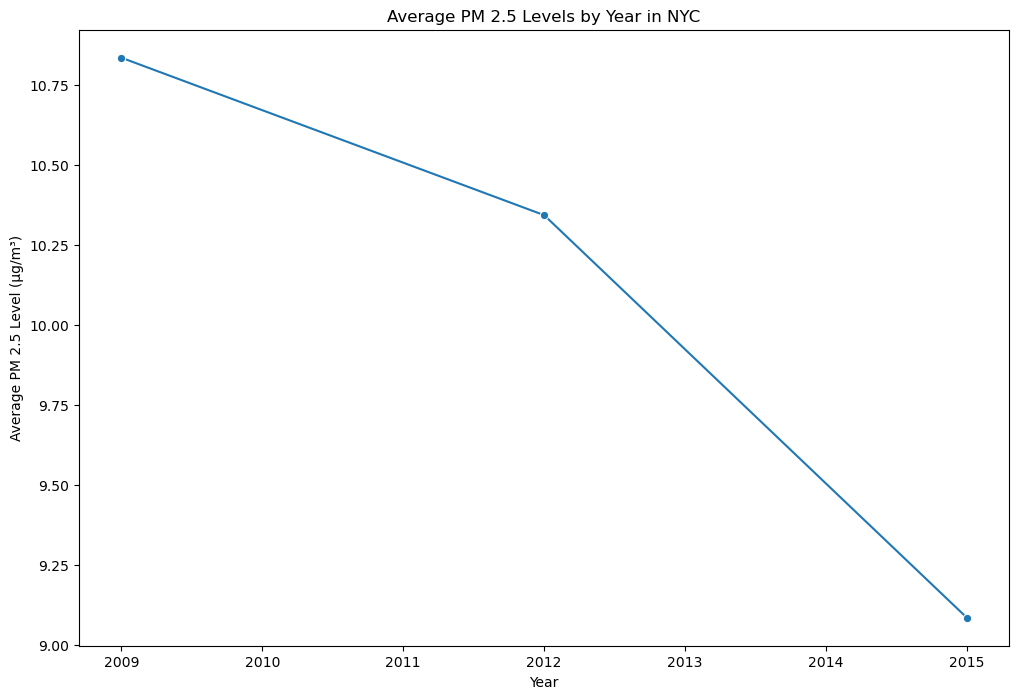

In [41]:

pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
pm_data_ = pm_data[pm_data['Year'].isin([2005, 2009, 2012, 2015])]
# Calculate the average PM 2.5 levels by year
avg_pm_by_year = pm_data_.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(x='Year', y='Data Value', data=avg_pm_by_year, ax=ax, marker='o')
plt.title('Average PM 2.5 Levels by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average PM 2.5 Level (µg/m³)')
plt.show()


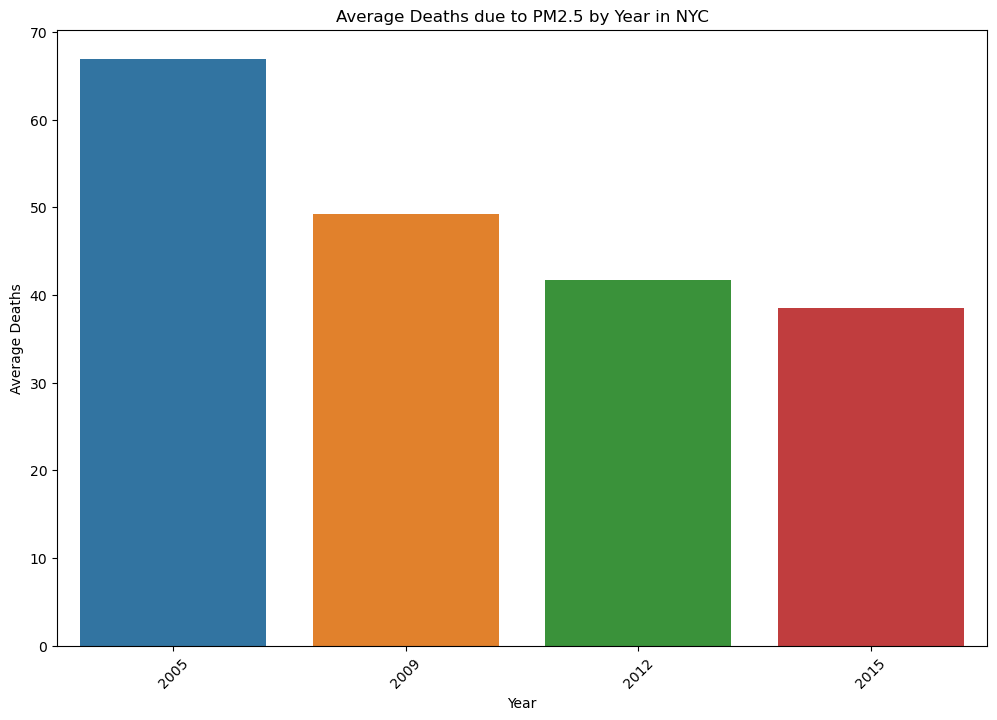

In [26]:
#分析一下Deaths due to PM2.5的按照年份的增长的柱状图
death_data = clean_data[clean_data['Name'] == 'Deaths due to PM2.5']
# Calculate the average deaths by year
avg_deaths_by_year = death_data.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Year', y='Data Value', data=avg_deaths_by_year, ax=ax)
plt.title('Average Deaths due to PM2.5 by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average Deaths')
plt.xticks(rotation=45)
plt.show()

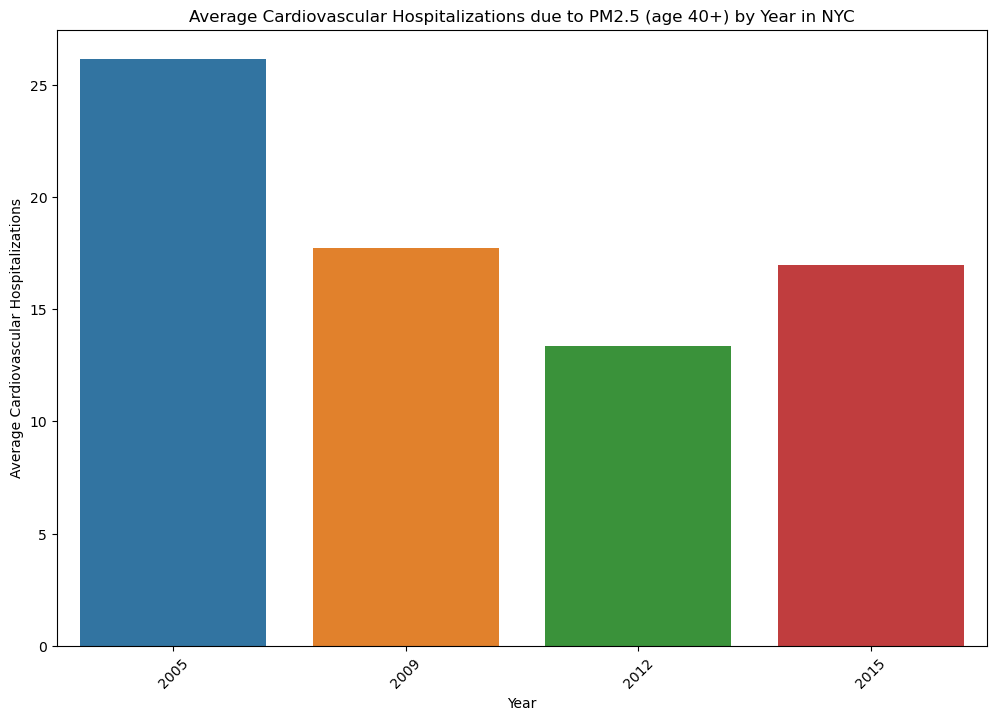

In [27]:
#分析一下Cardiovascular hospitalizations due to PM2.5 (age 40+) 按照年份的增长的柱状图
cardio_data = clean_data[clean_data['Name'] == 'Cardiovascular hospitalizations due to PM2.5 (age 40+)']
# Calculate the average cardiovascular hospitalizations by year
avg_cardio_by_year = cardio_data.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Year', y='Data Value', data=avg_cardio_by_year, ax=ax)
plt.title('Average Cardiovascular Hospitalizations due to PM2.5 (age 40+) by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average Cardiovascular Hospitalizations')
plt.xticks(rotation=45)
plt.show()


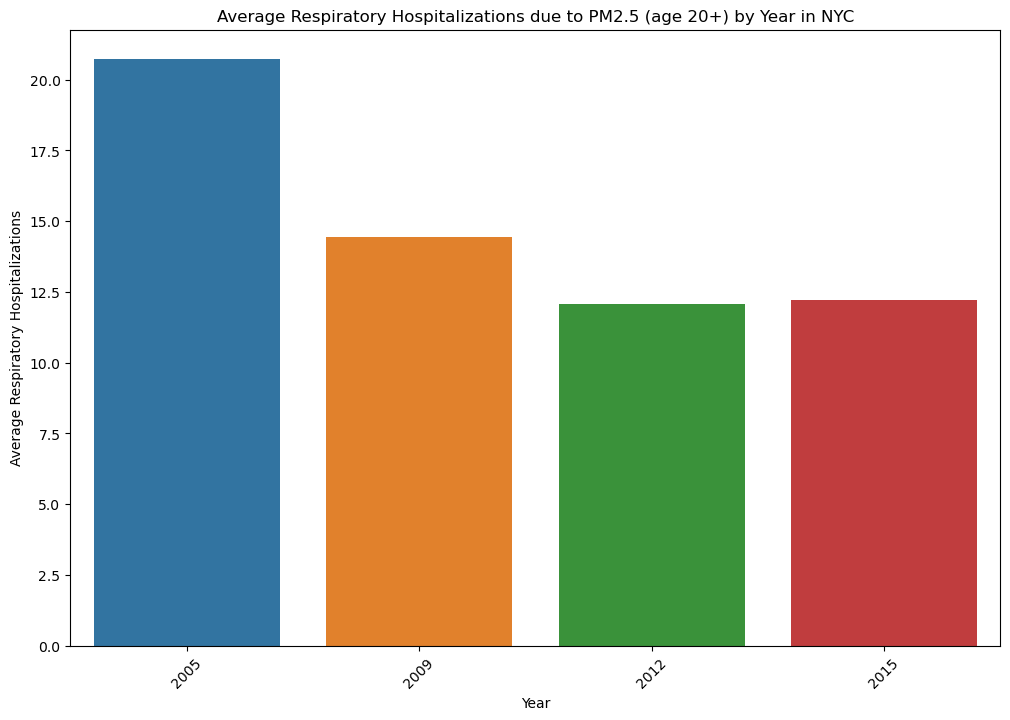

In [28]:
#分析一下Respiratory hospitalizations due to PM2.5 (age 20+)  按照年份的增长的柱状图
resp_data = clean_data[clean_data['Name'] == 'Respiratory hospitalizations due to PM2.5 (age 20+)']
# Calculate the average respiratory hospitalizations by year
avg_resp_by_year = resp_data.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x='Year', y='Data Value', data=avg_resp_by_year, ax=ax)
plt.title('Average Respiratory Hospitalizations due to PM2.5 (age 20+) by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average Respiratory Hospitalizations')
plt.xticks(rotation=45)
plt.show()

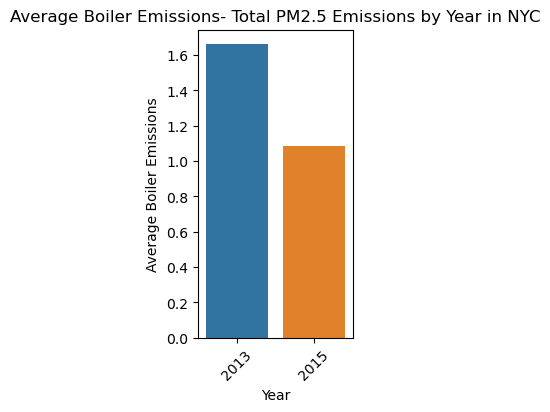

In [29]:
#画一下Boiler Emissions- Total PM2.5 Emissions 的年份的柱状图
boiler_data = clean_data[clean_data['Name'] == 'Boiler Emissions- Total PM2.5 Emissions']
# Calculate the average boiler emissions by year
avg_boiler_by_year = boiler_data.groupby('Year')['Data Value'].mean().reset_index()
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
sns.barplot(x='Year', y='Data Value', data=avg_boiler_by_year, ax=ax)
plt.title('Average Boiler Emissions- Total PM2.5 Emissions by Year in NYC')
plt.xlabel('Year')
plt.ylabel('Average Boiler Emissions')
plt.xticks(rotation=45)
plt.show()
